# Titanic: Machine Learning from Disaster

## Competition Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

Let's begin with importing the necessary modules for solving this problem. We'll be using `pandas` for manipulating the data in the CSVs, `matplotlib` for plotting the data and `sklearn` for our model for predicting the results.

In [2]:
# Import the necessary modules
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, grid_search
import os

# This is necessary to display the plots in the notebooks.
%matplotlib inline

In [3]:
# Prepare the data path
data_path = os.curdir + '/data/'
train_data_path = data_path + 'train.csv'
test_data_path = data_path + 'test.csv'

Now, let's load the training and testing data. Then, we'll observe some of the records in the training set.

In [4]:
# Load the training and testing data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
print(train_data.shape)
# Let's see what's in the dataset
train_data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From above output, we see that there are 891 rows of records and 12 columns. From this set, we'll select a few of the columns as our features for model training. The Survived column is our target which will be used during model fitting. Before getting into the training, let's see what information can be obtained from above data. Let's see what percentage of the passengers survived the disaster:

In [5]:
train_data.Survived.sum()/train_data.Survived.count()*100

38.38383838383838

It seems that only 38% of the total passengers were able to survive. Let's take a deeper dive to see the survived passengers according to the gender.

Sex
female    314
male      577
Name: Survived, dtype: int64
Sex
female    233
male      109
Name: Survived, dtype: int64


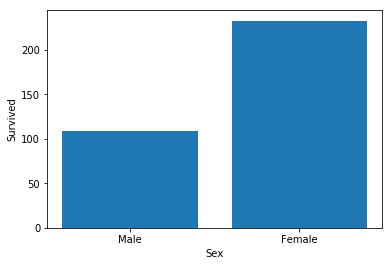

In [6]:
total_gender = train_data.groupby('Sex').Survived.count()
gender_survival = train_data.groupby('Sex').Survived.sum()
print(total_gender)
print(gender_survival)
male = gender_survival.male
female = gender_survival.female

fig, ax = plt.subplots()
bar_male, bar_female = plt.bar([1, 2], (male, female))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Male', 'Female'])
ax.set_xlabel('Sex')
ax.set_ylabel('Survived')

bar_male.set_height(male)
bar_female.set_height(female)

Out of 891 passengers, 577 were Male whereas 314 were Female. The bar diagram clearly shows that Female passengers were luckier to survive than the Male passengers. Out of 314 female, 233 survived whereas out of 577 male only 109 survived. Taking further look in the data to see how the class of the passengers affected their survival, let's see:

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64


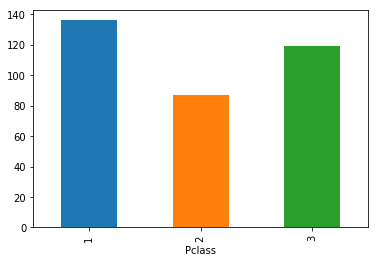

In [7]:
print(train_data.groupby('Pclass').Survived.sum())
train_data.groupby('Pclass').Survived.sum().plot(kind='bar')

It is clear that greater number of Class 1 passengers were able to survive than the Class 2 and Class 3. 136 of the Class 1, 87 of the Class 2 and 119 of the Class 3 passengers survived.

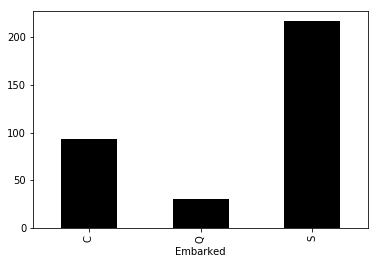

In [8]:
train_data.groupby('Embarked').Survived.sum().plot(kind='bar', colormap='bone')

On the basis of place of embarkment, it seems that the passengers embarked from S (Southampton) were more lucky to survive than that from C (Cherbourg) and  Q (Queenstown).

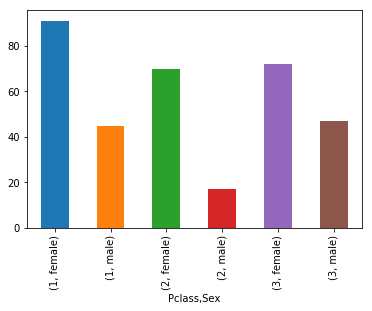

In [9]:
train_data.groupby(['Pclass', 'Sex']).Survived.sum().plot(kind='bar')

The above diagram shows the survival number for male and female passengers in specific Class.

### Dataset Cleaning and correction

If we observe the records in above dataset, we see that many of the records have `Nan` value i.e Not a Number. We cannot fit our model in presence of such values and must remove it.

In [10]:
train_data.Cabin.isna().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

Looking at the records, the Columns Cabin and Ticket seem to have most of the *NaN* values. So, we'll drop the Cabin and Ticket columns from our datasets. Then we'll drop  all the rows with any *NaN* values. If we had run `train_data.dropna()` before dropping Cabin, almost all our records would have been dropped because the `dropna()` function drops the records even if there's only a single *NaN* value in the record.

In [11]:
train_data = train_data.drop(['Cabin', 'Ticket'], axis=1)
train_data = train_data.dropna()

Let's prepare our data for training our model:

In [12]:
# Prepare the training features and target
target = train_data['Survived']
# features with continuous values
features_cont = train_data.loc[:, ['Age', 'SibSp']]
# features with categorical value
features_cat = train_data.loc[:, ['Pclass', 'Sex', 'Embarked']]

def embarked_conv(emb):
    if emb == 'S':
        return 1
    elif emb == 'Q':
        return 2
    else:
        return 3

# Convert categorical features from string to numeric for model fitting
features_cat['Sex'] = features_cat.Sex.apply(lambda sex: 1 if sex == 'male' else 2)
features_cat['Embarked'] = features_cat.Embarked.apply(lambda emb: embarked_conv(emb))

features = features_cont.join(features_cat)
features.head()

,Age,SibSp,Pclass,Sex,Embarked
0,22.0,1,3,1,1
1,38.0,1,1,2,3
2,26.0,0,3,2,1
3,35.0,1,1,2,1
4,35.0,0,3,1,1


Similarly, prepare the testing data:

In [13]:
# Drop the unnecessary data columns
test_data = test_data.drop(['Cabin', 'Ticket'], axis=1)
test_data = test_data.fillna(0)

# Prepare the testing features
test_features_cont = test_data.loc[:, ['Age', 'SibSp']]
test_features_cat = test_data.loc[:, ['Pclass', 'Sex', 'Embarked']]

test_features_cat['Sex'] = test_features_cat.Sex.apply(lambda sex: 1 if sex == 'male' else 2)
test_features_cat['Embarked'] = test_features_cat.Embarked.apply(lambda emb: embarked_conv(emb))

test_features = test_features_cont.join(test_features_cat)
test_features.head()

,Age,SibSp,Pclass,Sex,Embarked
0,34.5,0,3,1,2
1,47.0,1,3,2,1
2,62.0,0,2,1,2
3,27.0,0,3,1,1
4,22.0,1,3,2,1


### Model Training
Now, let's train our model. We'll be using a Support Vector Machine (SVM) Algorithm from sklearn module to train our model. First we'll prepare our classifier, then we'll fit our features and target using the classifier. Then, the model we'll be ready for predicting the survival in the test set.

In [14]:
# Prepare our SVM classifier
model = svm.SVC(C=1.0, kernel='rbf')

Here, we've used a Support Vector Classifier with the default parameters i.e C=1.0 and Radial Basis Function (rbf) kernel.

In [15]:
# Let's fit our data on the model.
model.fit(features, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

It's time for prediction:

In [16]:
predictions = model.predict(test_features)
predictions[:5]

array([0, 0, 0, 0, 1], dtype=int64)

The predictions is a numpy array of the values 0 and 1 where 1 stands for a survived passenger. Now, to submit the results to the Kaggle website, we need to save the predictions to a CSV file. Let's create a function for it.

In [17]:
# Here, model parameter is used only for naming, in case you use multiple models for testing.
def create_submission_file(predictions, model=""):
    submission_df = test_data.join(pd.DataFrame(predictions, columns=['Survived']))
    submission_df = submission_df.loc[:, ['PassengerId', 'Survived']]
    file_name = 'sub_' + model + '.csv'
    csv_file = open(file_name, 'w')
    submission_df.to_csv(csv_file, index=False)
    csv_file.close()
    return print('{} saved.'.format(file_name))

In [18]:
# Save the file.
create_submission_file(predictions, model='svm')

sub_svm.csv saved.


### Hyperparameters Tuning
With the default SVM classifier in sklearn without any parameter tuning, we get about 56% accuracy in the Kaggle Competition. Yes, it is low but that's the default configuration. Now, Let's try tuning the parameters for any improvement. We'll be using Cross Validated Grid Search from sklearn module to tune the parameters.

In [19]:
# Function definition for tuning
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search_var = grid_search.GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search_var.fit(X, y)
    grid_search_var.best_params_
    return grid_search_var.best_params_

In [20]:
svc_param_selection(features, target, 10)

{'C': 0.01, 'gamma': 0.001}

Now, using the tuned hyper parameters (and linear kernel) in our model for prediction:

In [21]:
tuned_model = svm.SVC(C=0.01, gamma=0.001, kernel='linear')
tuned_model.fit(features, target)
predictions = tuned_model.predict(test_features)
predictions[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [22]:
create_submission_file(predictions, model='svm-tuned')

sub_svm-tuned.csv saved.


After tuning, the predictions are about 73% accurate which is a great improvement from the previous one. We can tune further to improve our score.

We can also use Logistic Regression, Decision trees and ensemble algorithms like AdaBoost or Random Forests for this problem. The default sklearn classifier for each of these algorithms have almost the same accuracy without any hyperparameter tuning.